In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.model_output import YoloV3Output
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou

In [5]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [57]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

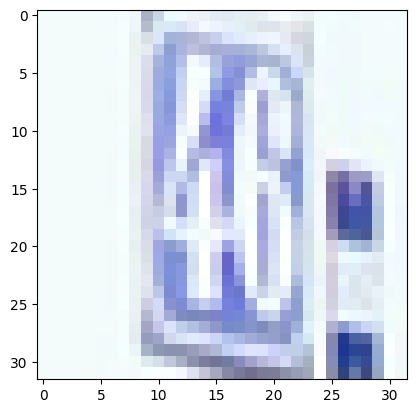

In [58]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

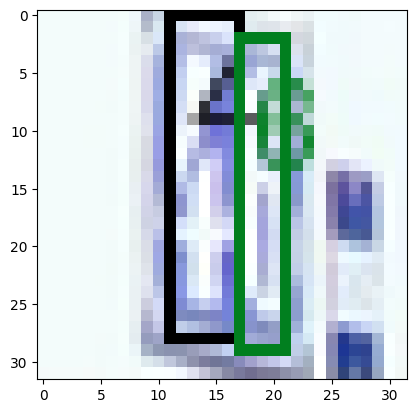

In [59]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [60]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [61]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]]), tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]])]
tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])


NameError: name 'anchors' is not defined

In [62]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [63]:
targets[0, 0, 0, :], targets[0, 1, 1, :]

NameError: name 'targets' is not defined

In [64]:
import json

In [65]:
torch.manual_seed(0)

config = json.load(open("./configs/smol.json", "r"))
model = MiniYoloV3.from_config(config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=5000,
    lr=3e-4,
    lambda_coord=1,
    lambda_noobj=1,
    device="cpu"
)

In [66]:
trainer.train()

100%|██████████| 5000/5000 [00:51<00:00, 97.74it/s, class_loss=0.0013, coord_loss=2.16e-5, loss=0.039, noobj_loss=0.0233, obj_conf_loss=0.0144]    


[48.757232666015625,
 46.33184814453125,
 44.116947174072266,
 44.18216323852539,
 46.982662200927734,
 46.45512771606445,
 45.825531005859375,
 45.25124740600586,
 44.65534591674805,
 44.07718276977539,
 43.55887985229492,
 43.07986068725586,
 42.60921096801758,
 42.155521392822266,
 39.9441032409668,
 39.526161193847656,
 39.026649475097656,
 38.483367919921875,
 37.900482177734375,
 37.2880973815918,
 36.65207290649414,
 36.03764343261719,
 35.39216613769531,
 34.6833381652832,
 33.928043365478516,
 33.1328010559082,
 32.329673767089844,
 31.542442321777344,
 38.55314254760742,
 38.42998123168945,
 30.206039428710938,
 29.689212799072266,
 29.171951293945312,
 28.633548736572266,
 28.087085723876953,
 27.543304443359375,
 27.011619567871094,
 26.497751235961914,
 26.00619125366211,
 25.540395736694336,
 25.090145111083984,
 24.639772415161133,
 24.20087432861328,
 23.776113510131836,
 23.369653701782227,
 22.983142852783203,
 22.61689567565918,
 22.27176856994629,
 21.94827842712402

In [67]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 8, 8, 60])

In [68]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([ 0.0715,  0.6145,  0.0809, -0.1748, -6.2709, -0.0823,  0.2571, -0.5676,
         -0.2738,  0.1713, -0.3432,  0.1378, -0.3415,  0.2905, -0.6287, -0.6188,
          0.0947, -0.3606,  0.4675, -0.1564, -0.2574, -0.6639, -0.0905, -0.1194,
         -0.3105, -0.5644,  0.1333, -0.0818, -0.2452, -0.3187, -0.1392,  0.6440,
         -0.1050, -0.0314, -0.0534, -0.5836,  0.1980,  0.2313,  0.0801,  0.0068,
          0.3339,  0.2863,  0.4783, -0.0564, -0.1607, -0.0831,  0.0274, -0.4373,
          0.1273,  0.0081, -0.2210,  0.0269,  0.0078,  0.2766, -0.4831,  0.4183,
          0.1616, -0.0126, -0.1221, -0.0347], grad_fn=<SliceBackward0>),
 tensor([ 1.1636e-01,  1.1123e+00,  5.0192e-02, -1.0446e-01, -5.9488e+00,
         -7.2863e-01,  8.4605e-01, -1.2182e+00, -1.0496e+00, -6.4392e-01,
         -7.7009e-01, -1.0527e+00, -6.3848e-01, -4.8543e-01, -1.2221e+00,
         -2.2888e-01,  1.5069e-01, -2.8584e-01,  3.4526e-01, -2.1529e-01,
         -4.6476e-01, -4.7121e-01, -2.8358e-01, -1.4320e-01, -3.

In [69]:
output = YoloV3Output(pred, model.anchors, 10)

In [70]:
bounding_boxes = output.bounding_boxes(0.95)

NMS
torch.Size([256, 15])
torch.Size([2, 15])
torch.Size([2, 15])
NMS
torch.Size([256, 15])
torch.Size([3, 15])
torch.Size([3, 15])


In [71]:
bounding_boxes

[{'bboxes': tensor([[0.3551, 0.0216, 0.1963, 0.8698],
          [0.5327, 0.0652, 0.1495, 0.8696]]),
  'confidence': tensor([10.9877,  3.9091]),
  'labels': tensor([4, 6]),
  'scores': tensor([1.0000, 0.9982])},
 {'bboxes': tensor([[0.3442, 0.1290, 0.1968, 0.7420],
          [0.5082, 0.1611, 0.1639, 0.7419],
          [0.3779, 0.1965, 0.1133, 0.6071]]),
  'confidence': tensor([4.1385, 3.8180, 3.6018]),
  'labels': tensor([7, 1, 4]),
  'scores': tensor([0.9978, 0.9988, 0.5826])}]

In [72]:
i = 0

In [78]:
output = model.inference(
    batch["images"]
)

bounding_boxes = output.bboxes
bounding_boxes

yo
torch.Size([2, 15])
torch.Size([2])
torch.Size([6, 15])
torch.Size([6])


[{'bboxes': tensor([[0.4533, 0.4565, 0.1963, 0.8698],
          [0.6075, 0.5000, 0.1495, 0.8696]]),
  'confidence': tensor([1.0000, 0.9803]),
  'labels': tensor([4, 6]),
  'scores': tensor([1.0000, 0.9982])},
 {'bboxes': tensor([[0.4426, 0.5000, 0.1968, 0.7420],
          [0.5902, 0.5320, 0.1639, 0.7419],
          [0.4346, 0.5000, 0.1133, 0.6071],
          [0.5573, 0.7175, 0.1943, 1.0572],
          [0.2642, 0.5418, 0.4926, 0.1195],
          [0.2617, 0.6615, 0.4319, 0.1114]]),
  'confidence': tensor([0.9843, 0.9785, 0.9734, 0.9367, 0.9303, 0.9195]),
  'labels': tensor([7, 1, 4, 4, 4, 4]),
  'scores': tensor([0.9978, 0.9988, 0.5826, 0.6573, 0.3006, 0.3183])}]

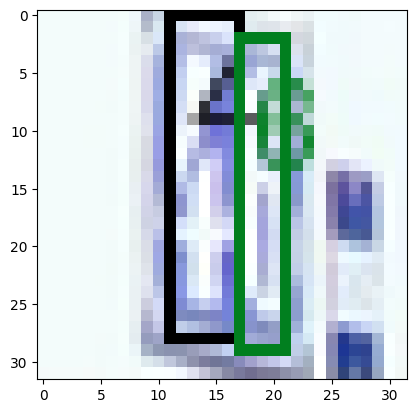

In [81]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

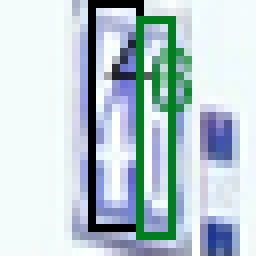

In [84]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [76]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'images': tensor([[[[0.3922, 0.3882, 0.3961,  ..., 0.0980, 0.1020, 0.1020],
          [0.3922, 0.3922, 0.4000,  ..., 0.0902, 0.1020, 0.1020],
          [0.3961, 0.4000, 0.3961,  ..., 0.1020, 0.0941, 0.1020],
          ...,
          [0.4157, 0.4118, 0.4196,  ..., 0.1333, 0.1137, 0.1137],
          [0.4157, 0.4118, 0.4196,  ..., 0.1373, 0.1176, 0.1176],
          [0.4078, 0.4157, 0.4235,  ..., 0.1373, 0.1098, 0.1137]],

         [[0.3569, 0.3608, 0.3647,  ..., 0.1137, 0.1333, 0.1451],
          [0.3569, 0.3647, 0.3686,  ..., 0.1020, 0.1333, 0.1451],
          [0.3686, 0.3686, 0.3765,  ..., 0.1176, 0.1294, 0.1490],
          ...,
          [0.4157, 0.4118, 0.4078,  ..., 0.1451, 0.1412, 0.1490],
          [0.4157, 0.4118, 0.4078,  ..., 0.1490, 0.1451, 0.1529],
          [0.4078, 0.4157, 0.4118,  ..., 0.1490, 0.1373, 0.1490]],

         [[0.3216, 0.3412, 0.3647,  ..., 0.1961, 0.1647, 0.1294],
          [0.3216, 0.3412, 0.3686,  ..., 0.1843, 0.1647, 0.1294],
          [0.3294, 0.3490, 0.36

In [50]:
bboxes = bounding_boxes[0]["bboxes"]
bboxes.shape

torch.Size([1, 4])

In [51]:
model.inference(
    batch["images"]
)

yo
torch.Size([256, 15])
torch.Size([104])
torch.Size([256, 15])
torch.Size([103])


MiniYoloV3Output(pred=tensor([[[[ 2.6301e-01,  1.1285e+00,  2.8023e-01,  ...,  2.8835e-02,
           -1.4927e-01, -4.9492e-02],
          [ 1.7022e-01,  1.4169e+00,  2.0000e-01,  ...,  5.4323e-01,
           -3.7553e-01, -8.5517e-03],
          [-1.5368e-02,  1.9937e+00,  3.9534e-02,  ...,  1.5741e-01,
           -2.5589e-02, -1.4577e-01],
          ...,
          [ 2.0871e-01,  2.6044e+00,  4.2321e-02,  ...,  2.9484e-01,
           -3.1334e-01, -1.9578e-01],
          [ 8.4038e-03,  3.7432e+00, -3.7127e-01,  ...,  1.4897e-01,
           -8.3144e-04, -4.7474e-01],
          [-9.1751e-02,  4.3127e+00, -5.7807e-01,  ..., -5.8029e-03,
            4.9528e-03, -1.6364e-01]],

         [[ 1.9098e-01,  8.7562e-01,  3.5471e-01,  ...,  1.4443e-02,
           -2.1448e-01,  4.5689e-02],
          [ 8.6966e-02,  9.7153e-01,  2.4274e-01,  ...,  7.4344e-02,
           -4.5126e-01,  1.1620e-01],
          [-1.2106e-01,  1.1634e+00,  1.8820e-02,  ...,  1.3752e-01,
            3.9443e-01,  9.8745e-02]

In [109]:
model.inference(batch["images"])